In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle competitions download -c titanic


  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 36.8MB/s]


In [5]:
!unzip titanic.zip


Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [22]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


In [23]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [24]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [26]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [27]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [28]:

embarked_imputer = SimpleImputer(strategy='most_frequent')
embarked_imputer =embarked_imputer.fit(train_df[['Embarked']])
train_df['Embarked'] = embarked_imputer.transform(train_df[['Embarked']]).ravel()
test_df['Embarked'] = embarked_imputer.transform(test_df[['Embarked']]).ravel()

In [29]:
age_imputer = SimpleImputer(strategy='mean')
age_imputer=age_imputer.fit(train_df[['Age']])
train_df['Age'] = age_imputer.transform(train_df[['Age']])
test_df['Age'] = age_imputer.transform(test_df[['Age']])

In [30]:

train_df.drop(columns=['Cabin'], inplace=True)
test_df.drop(columns=['Cabin'], inplace=True)

In [31]:
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

std_scaler = MinMaxScaler(feature_range=(-1,1))
std_scaler =std_scaler.fit(train_df[numerical_features])

train_df[numerical_features] = std_scaler.transform(train_df[numerical_features])
test_df[numerical_features] = std_scaler.transform(test_df[numerical_features])

In [32]:
train_df.drop_duplicates(inplace=True)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    float64
 7   Parch        891 non-null    float64
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(4), int64(3), object(4)
memory usage: 76.7+ KB


In [34]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)

onehot_encoder = onehot_encoder.fit(train_df[['Sex']])
train_sex_encoder= onehot_encoder.transform(train_df[['Sex']])
test_sex_encoder = onehot_encoder.transform(test_df[['Sex']])

In [35]:

train_df = pd.concat([train_df.drop(columns=['Sex']), pd.DataFrame(train_sex_encoder, columns=onehot_encoder.get_feature_names_out(['Sex']))], axis=1)
test_df = pd.concat([test_df.drop(columns=['Sex']), pd.DataFrame(test_sex_encoder, columns=onehot_encoder.get_feature_names_out(['Sex']))], axis=1)


In [36]:
onehot_encoder = OneHotEncoder(sparse_output=False)

onehot_encoder = onehot_encoder.fit(train_df[['Embarked']])
train_Embarked_encoder= onehot_encoder.transform(train_df[['Embarked']])
test_Embarked_encoder = onehot_encoder.transform(test_df[['Embarked']])

In [37]:
train_df = pd.concat([train_df.drop(columns=['Embarked']), pd.DataFrame(train_Embarked_encoder, columns=onehot_encoder.get_feature_names_out(['Embarked']))], axis=1)
test_df = pd.concat([test_df.drop(columns=['Embarked']), pd.DataFrame(test_Embarked_encoder, columns=onehot_encoder.get_feature_names_out(['Embarked']))], axis=1)


In [38]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",-0.457653,-0.75,-1.0,A/5 21171,-0.971698,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",-0.055542,-0.75,-1.0,PC 17599,-0.721729,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",-0.357125,-1.00,-1.0,STON/O2. 3101282,-0.969063,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",-0.130937,-0.75,-1.0,113803,-0.792711,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",-0.130937,-1.00,-1.0,373450,-0.968575,0.0,1.0,0.0,0.0,1.0


In [39]:
numeric_columns = train_df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
print(correlation_matrix)

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.033207 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.069809 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.331339  0.083081  0.018443   
Age             0.033207 -0.069809 -0.331339  1.000000 -0.232625 -0.179191   
SibSp          -0.057527 -0.035322  0.083081 -0.232625  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.179191  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.091566  0.159651  0.216225   
Sex_female     -0.042939  0.543351 -0.131900 -0.084153  0.114631  0.245489   
Sex_male        0.042939 -0.543351  0.131900  0.084153 -0.114631 -0.245489   
Embarked_C     -0.001205  0.168240 -0.243292  0.032024 -0.059528 -0.011069   
Embarked_Q     -0.033606  0.003650  0.221009 -0.013855 -0.026354 -0.081228   
Embarked_S      0.022204 -0.149683  0.074053 -0.019336  0.068734

In [40]:
X = train_df.drop(labels=['Name','Survived','PassengerId','Ticket'],axis=1)
y =train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# نموذج Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# حساب الدقة والاسترجاع
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)

print(f"Logistic Regression - Precision: {precision_log_reg:.2f}, Recall: {recall_log_reg:.2f}")

Logistic Regression - Precision: 0.78, Recall: 0.73


In [43]:
# تجربة معايير ضبط مختلفة لنموذج Logistic Regression
log_reg1 = LogisticRegression(C=0.1)
log_reg1.fit(X_train, y_train)
y_pred_log_reg1 = log_reg1.predict(X_test)
rf_clf = RandomForestClassifier(random_state=42)

cv_params ={
    'n_estimators':[50,75,100],
    'max_depth':[3,5,8],
    'min_samples_split':[0.25,0.3,0.4],
    'max_features':[4,6,8],
    'max_samples':[.2,.4,.6]
}

scoring=['precision','recall','f1','accuracy']

# حساب الدقة والاسترجاع
precision_log_reg1 = precision_score(y_test, y_pred_log_reg1)
recall_log_reg1 = recall_score(y_test, y_pred_log_reg1)

rf_cv = GridSearchCV(rf_clf,param_grid=cv_params,cv=5,scoring= scoring,refit='accuracy')
rf_cv.fit(X_train,y_train)
print(f"Logistic Regression1 (C=0.1) - Precision: {precision_log_reg1:.2f}, Recall: {recall_log_reg1:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Logistic Regression1 (C=0.1) - Precision: 0.76, Recall: 0.72


In [44]:
# نموذج Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# حساب الدقة والاسترجاع
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print(f"Random Forest - Precision: {precision_rf:.2f}, Recall: {recall_rf:.2f}")


Random Forest - Precision: 0.81, Recall: 0.74


Random Forest1 (n_estimators=100, max_depth=5) - Precision: 0.81, Recall: 0.70
Recall:     0.73
Precision:  0.783
Accuracy:   0.804
F1 score:   0.755


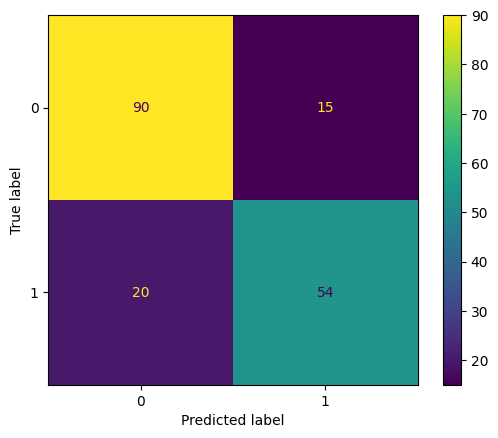

In [45]:
# تجربة معايير ضبط مختلفة لنموذج Random Forest
rf_clf1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf1.fit(X_train, y_train)
y_pred_rf1 = rf_clf1.predict(X_test)

# حساب الدقة والاسترجاع
precision_rf1 = precision_score(y_test, y_pred_rf1)
recall_rf1 = recall_score(y_test, y_pred_rf1)

print(f"Random Forest1 (n_estimators=100, max_depth=5) - Precision: {precision_rf1:.2f}, Recall: {recall_rf1:.2f}")
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,\
                            recall_score,precision_score, f1_score, accuracy_score
def model_evaluation(actual,pred):
    print('Recall:    ',recall_score(actual,pred).round(3),end='\n')
    print('Precision: ',precision_score(actual,pred).round(3),end='\n')
    print('Accuracy:  ',accuracy_score(actual,pred).round(3),end='\n')
    print('F1 score:  ',f1_score(actual,pred).round(3),end='\n')

    cm = confusion_matrix(actual,pred)
    ConfusionMatrixDisplay(cm).plot()
model_evaluation(y_test,y_pred_log_reg)


In [46]:
from sklearn.svm import SVC
# نموذج SVM بمعاملات افتراضية
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# حساب الدقة والاسترجاع
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)

print(f"SVM (Default) - Precision: {precision_svm:.2f}, Recall: {recall_svm:.2f}")


SVM (Default) - Precision: 0.77, Recall: 0.69


In [47]:
# تجربة معايير ضبط مختلفة لنموذج SVM
svm_clf_custom1 = SVC(C=1.0, kernel='linear', random_state=42)
svm_clf_custom1.fit(X_train, y_train)
y_pred_svm_custom1 = svm_clf_custom1.predict(X_test)

# حساب الدقة والاسترجاع
precision_svm_custom1 = precision_score(y_test, y_pred_svm_custom1)
recall_svm_custom1 = recall_score(y_test, y_pred_svm_custom1)

print(f"SVM (C=1.0, kernel='linear') - Precision: {precision_svm_custom1:.2f}, Recall: {recall_svm_custom1:.2f}")


SVM (C=1.0, kernel='linear') - Precision: 0.75, Recall: 0.70


In [48]:
from sklearn.tree import DecisionTreeClassifier
# نموذج Decision Tree بمعاملات افتراضية
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

# حساب الدقة والاسترجاع
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

print(f"Decision Tree (Default) - Precision: {precision_dt:.2f},Recall:{recall_dt:.2f}")


Decision Tree (Default) - Precision: 0.75,Recall:0.76


In [49]:
# إنشاء خط أنابيب
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('classifier', RandomForestClassifier(random_state=42))
])

# تعريف معايير الضبط للبحث الشبكي
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# استخدام GridSearchCV لضبط معايير الضبط
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# أفضل معايير ضبط
print(f"Best parameters: {grid_search.best_params_}")

# التنبؤ باستخدام النموذج الأفضل
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# تقييم الأداء
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Random Forest - Best Model - Precision: {precision:.2f}, Recall: {recall:.2f}")


Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Random Forest - Best Model - Precision: 0.81, Recall: 0.69


In [50]:
# تقييم النموذج باستخدام Cross-Validation
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='precision')
print(f"Cross-Validation Precision scores: {cross_val_scores}")
print(f"Mean Cross-Validation Precision: {cross_val_scores.mean():.2f}")


Cross-Validation Precision scores: [0.81034483 0.8        0.81355932 0.84444444 0.84745763]
Mean Cross-Validation Precision: 0.82


Logistic Regression:
Recall:     0.73
Precision:  0.783
Accuracy:   0.804
F1 score:   0.755

Random Forest:
Recall:     0.743
Precision:  0.809
Accuracy:   0.821
F1 score:   0.775

Support Vector Machine:
Recall:     0.689
Precision:  0.773
Accuracy:   0.788
F1 score:   0.729

Decision Tree:
Recall:     0.757
Precision:  0.747
Accuracy:   0.793
F1 score:   0.752


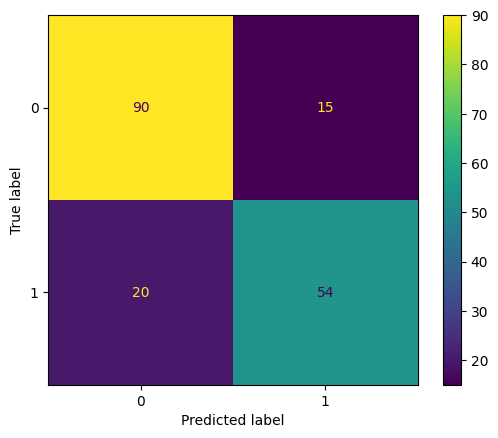

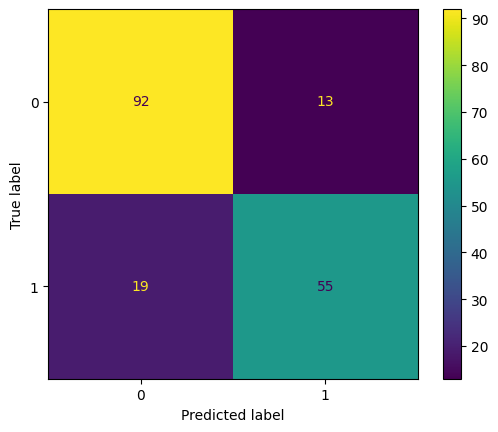

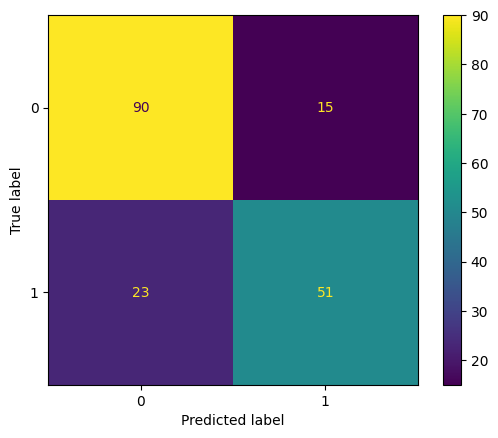

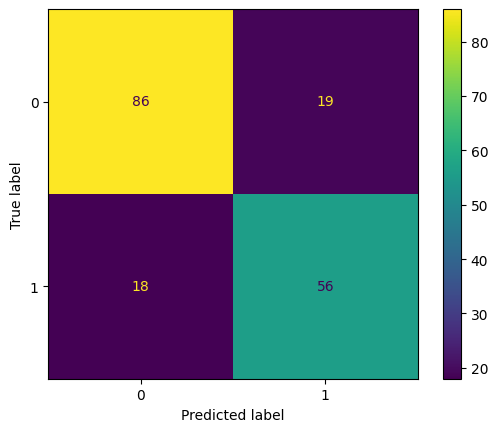

In [51]:
# وظيفة لتقييم النماذج المختلفة
def model_evaluation(actual, pred):
    print('Recall:    ', recall_score(actual, pred).round(3))
    print('Precision: ', precision_score(actual, pred).round(3))
    print('Accuracy:  ', accuracy_score(actual, pred).round(3))
    print('F1 score:  ', f1_score(actual, pred).round(3))

    cm = confusion_matrix(actual, pred)
    ConfusionMatrixDisplay(cm).plot()

# تقييم النماذج المختلفة
print("Logistic Regression:")
model_evaluation(y_test, y_pred_log_reg)

print("\nRandom Forest:")
model_evaluation(y_test, y_pred_rf)

print("\nSupport Vector Machine:")
model_evaluation(y_test, y_pred_svm)

print("\nDecision Tree:")
model_evaluation(y_test, y_pred_dt)
